# Kaggle Pneumonia XRay Test

In [1]:
RUN_NAME = '20210104 - Pneum XRay Reboot a'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set sensible default parameters for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

plt.style.use('dark_background')

In [2]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
import fastai
from fastai.callback.wandb import *

%env WANDB_WATCH=false
import wandb
wandb.login()
wandb.init(project='Kaggle Pneumonia XRay')
wandb.run.name = RUN_NAME
wandb.run.save()

plt.style.use('classic')

mean = np.zeros((1,))
std = np.zeros((1,))


env: WANDB_WATCH=false


wandb: Currently logged in as: cogsci2 (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


<br>
<br>

## Check for an available GPU

In [3]:
import torch
print('CUDA available: '.ljust(25), torch.cuda.is_available())
print('CUDA device count: '.ljust(25), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device num: '.ljust(25), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(25), torch.cuda.get_device_name(current_device))

CUDA available:           True
CUDA device count:        1
Current CUDA Device num:  0
Current CUDA Device:      GeForce RTX 2070 SUPER


In [4]:
path = './train'

<br>
<br>

## Check for Balance - the Number of Images in Each Class

In [5]:
viral_fnames = get_image_files(path + '/PVI')
bac_fnames = get_image_files(path + '/PBAC')
delta = len(bac_fnames) - len(viral_fnames)
print('len(bac_fnames)     : ', len(bac_fnames))
print('len(viral_fnames)   : ', len(viral_fnames))
print()
print('delta               : ', delta)


len(bac_fnames)     :  2772
len(viral_fnames)   :  1493
delta               :  1279


## Rebalance the Dataset by Oversampling the Virus Data

(See <a href="https://arxiv.org/abs/1710.05381">A systematic study of the class imbalance problem in convolutional neural networks by Buda, et al</a> for why oversampling is often the best method for correcting imbalance issues.)

In [6]:
vi_df = pd.DataFrame(list(viral_fnames))
additional_vi = vi_df.sample(delta)
vi_df = vi_df.append(additional_vi)
upsampled_viral_fnames = L(list(vi_df.values.reshape(2772,)))


In [7]:
print('len(upsampled_viral_fnames): ', len(upsampled_viral_fnames))
print('len(bac_fnames):             ', len(bac_fnames))

len(upsampled_viral_fnames):  2772
len(bac_fnames):              2772


In [8]:
def get_fnames(path):
    fnames = upsampled_viral_fnames + bac_fnames
#     fnames.append(upsampled_viral_fnames)
#     fnames.append(bac_fnames)
#     fnames.pop(0)
    return fnames * 4  # Increase the amount of data - it gets augmented/randomized later


In [9]:
get_fnames('/')

(#22176) [Path('train/PVI/person1060_virus_1760.jpeg'),Path('train/PVI/person813_virus_1449.jpeg'),Path('train/PVI/person1448_virus_2468.jpeg'),Path('train/PVI/person826_virus_1462.jpeg'),Path('train/PVI/person1264_virus_2155.jpeg'),Path('train/PVI/person1341_virus_2313.jpeg'),Path('train/PVI/person1369_virus_2355.jpeg'),Path('train/PVI/person811_virus_1447.jpeg'),Path('train/PVI/person1300_virus_2240.jpeg'),Path('train/PVI/person115_virus_219.jpeg')...]

In [10]:
get_image_files(path)

(#4265) [Path('train/PBAC/person600_bacteria_2458.jpeg'),Path('train/PBAC/person87_bacteria_433.jpeg'),Path('train/PBAC/person1637_bacteria_4339.jpeg'),Path('train/PBAC/person1897_bacteria_4789.jpeg'),Path('train/PBAC/person125_bacteria_594.jpeg'),Path('train/PBAC/person992_bacteria_2920.jpeg'),Path('train/PBAC/person146_bacteria_703.jpeg'),Path('train/PBAC/person1399_bacteria_3549.jpeg'),Path('train/PBAC/person452_bacteria_1943.jpeg'),Path('train/PBAC/person364_bacteria_1659.jpeg')...]

<br>

### Create the DataBlock

In [11]:
# tfms = setup_aug_tfms([Normalize.from_stats(mean, std)])
tfms = aug_transforms(size=300, do_flip=False, batch=True)

In [12]:
imgs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(300, method='bilinear'),
    batch_tfms=tfms)
    
    
#     batch_tfms=Normalize.from_stats(mean=0.5, std=0.1))    
#     batch_tfms=Normalize.from_stats(*imagenet_stats))

In [13]:
# imgs.normalize()

<br>

## Resize and add basic image augmentation

In [14]:
# signs = signs.new(item_tfms=Resize(128, method=ResizeMethod.Squish), 
#                   batch_tfms=aug_transforms(mult=1.4, max_zoom=1))
# imgs = imgs.new(item_tfms=Resize(160, method=ResizeMethod.Squish))

# signs.apply_tfms(Image.flip)
# imgs.apply_tfms(Normalize.from_stats(*imagenet_stats))
# imgs.transform(Normalize.from_stats(*imagenet_stats))

<br>

### Load the data by path

In [15]:
dls = imgs.dataloaders(path, batch_size=32)

In [16]:
# means = [xb.mean(dim=(0, 2, 3)) for xb, yb in dls.train]
# stds = [xb.std(dim=(0, 2, 3)) for xb, yb in dls.train]
# mean, std = torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)
# print(mean, std)

<br>

### Verify the Training and Validation Batches

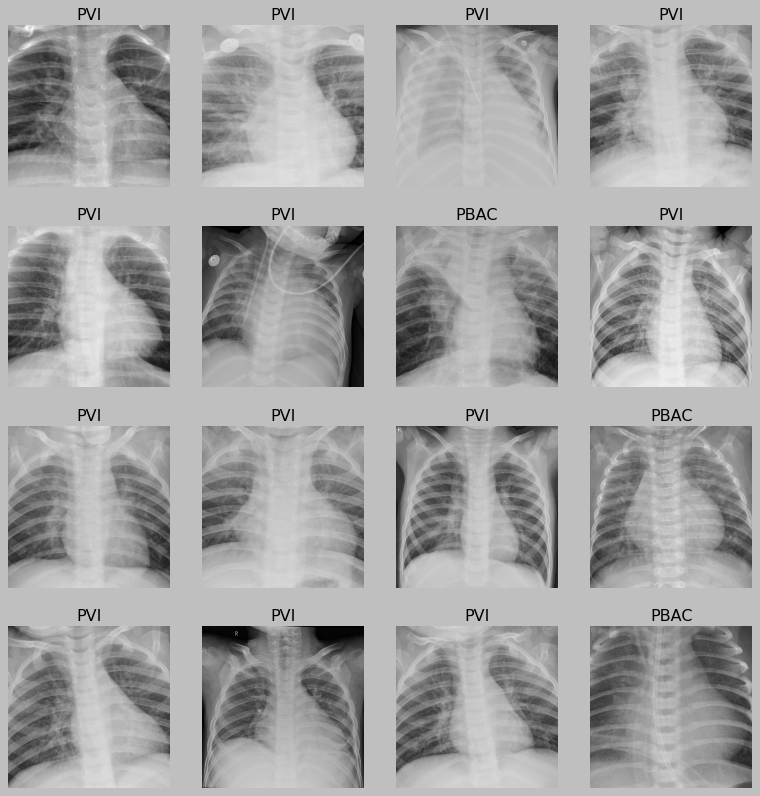

In [17]:
dls.valid.show_batch(max_n=16, nrows=4)

<br>

### Define the model (Resnet50) and fit

In [18]:
learn = cnn_learner(dls, resnet50 , metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

<br>
<br>

#### Look at the Loss function

In [19]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

#### Look at the Optimization Function

In [20]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

### Look at the Model Architecture

In [21]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

<br>
<br>

### Define an Early Stopping and WandB Callbacks

In [22]:
early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=2)
wandbcb = WandbCallback(log='all')

<br>
<br>

## Find an Appropriate Learning Rate

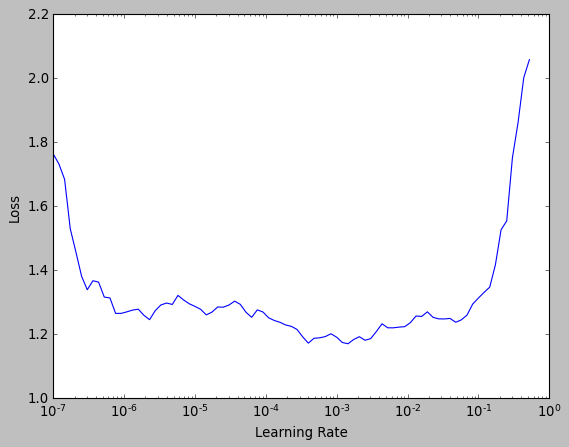

In [23]:
lr_min,lr_steep = learn.lr_find() 


In [24]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.45e-04, steepest point: 6.31e-07


<br>
<br>

## Fit the Model

In [25]:
learn.fine_tune(10, cbs=[early_stop, wandbcb, SaveModelCallback()] )

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.609647,0.514409,0.237823,0.762177,0.772570,0.745974,0.801133,04:14


Better model found at epoch 0 with valid_loss value: 0.5144094228744507.


wandb: Adding directory to artifact (/tmp/tmp75zpaw_l)... Done. 0.2s


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.385653,0.330788,0.132892,0.867108,0.874396,0.835233,0.917412,05:29
1,0.320479,0.293122,0.115604,0.884396,0.887852,0.868969,0.907573,05:29
2,0.279066,0.214263,0.081630,0.918370,0.921018,0.899176,0.943948,05:24
3,0.215245,0.140466,0.056374,0.943626,0.946436,0.908418,0.987776,05:14
4,0.164343,0.122081,0.042694,0.957306,0.958817,0.933371,0.985689,05:15
5,0.102297,0.070262,0.020896,0.979104,0.979349,0.976014,0.982707,05:14
6,0.062165,0.028765,0.008419,0.991581,0.991696,0.986431,0.997018,05:14
7,0.031136,0.027331,0.010072,0.989928,0.990111,0.980415,1.000000,05:15
8,0.014184,0.010396,0.003307,0.996693,0.996731,0.993483,1.000000,05:15
9,0.020613,0.012885,0.003458,0.996542,0.996583,0.993189,1.000000,05:14


Exception ignored in: <finalize object at 0x7f80443d92b0; dead>
Traceback (most recent call last):
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/tempfile.py", line 797, in _cleanup
    _shutil.rmtree(name)
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp75zpaw_l'


Better model found at epoch 0 with valid_loss value: 0.3307882249355316.
Better model found at epoch 1 with valid_loss value: 0.29312193393707275.
Better model found at epoch 2 with valid_loss value: 0.2142631858587265.
Better model found at epoch 3 with valid_loss value: 0.1404661238193512.
Better model found at epoch 4 with valid_loss value: 0.12208126485347748.
Better model found at epoch 5 with valid_loss value: 0.07026167958974838.
Better model found at epoch 6 with valid_loss value: 0.028764931485056877.
Better model found at epoch 7 with valid_loss value: 0.02733144536614418.
Better model found at epoch 8 with valid_loss value: 0.010396208614110947.


wandb: Adding directory to artifact (/tmp/tmpbk8m2wor)... Done. 0.2s


In [26]:
# learn.fine_tune(100, base_lr=3e-4, cbs=[early_stop] )

In [27]:
learn.unfreeze()


In [28]:
# learn.fit_one_cycle(5, cbs=[early_stop, wandbcb, SaveModelCallback()] )

<br>

### Plot Losses

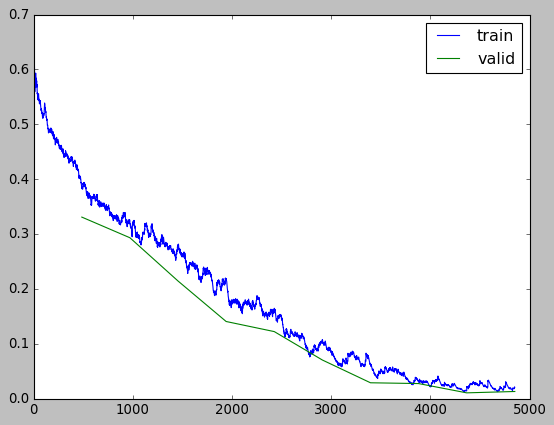

In [29]:
learn.recorder.plot_loss()

<br>

### Visualize with a confusion Matrix

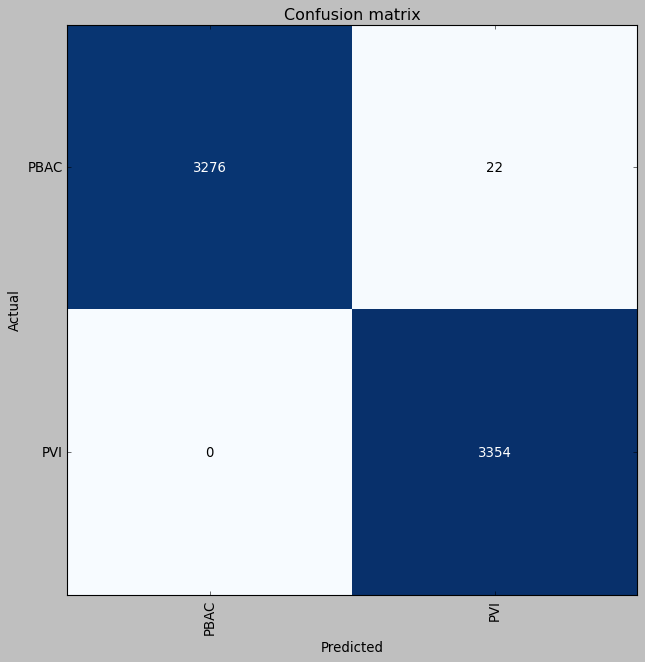

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [31]:
interp.print_classification_report()

              precision    recall  f1-score   support

        PBAC       1.00      0.99      1.00      3298
         PVI       0.99      1.00      1.00      3354

    accuracy                           1.00      6652
   macro avg       1.00      1.00      1.00      6652
weighted avg       1.00      1.00      1.00      6652



<br>

### Show the top 5 most error prone images

In [32]:
# interp.plot_top_losses(12, nrows=4)

In [33]:
# learn.predict('./val/NORMAL/NORMAL2-IM-1430-0001.jpeg')

In [34]:
learn.predict('./val/PNEUMONIA/person1946_bacteria_4874.jpeg')

('PBAC', tensor(0), tensor([9.9983e-01, 1.7372e-04]))

<br>
<br>

---

<br>
<br>

## Persist the Model

<br>
<br>

In [35]:
# wandb.save('./models/210103.h5')

In [36]:
learn.export('models/20210103a.pkl')
path = Path('models')
path.ls(file_exts='.pkl')

(#2) [Path('models/20200103.pkl'),Path('models/20210103a.pkl')]

In [37]:
# %cd ..

In [38]:
# learn.save('save/200921-0121-export-resnet101-FALL-tune2ft-tune6un-tune2ft')

In [39]:
# learn_inf = load_learner(path/'export.pkl')

In [40]:
!pwd

/home/frank/Insync/cogsci2@gmail.com/Google Drive/Study Notes/00-Personal Repos/Chest XRays/chest_xray


In [41]:
wandb.join()

epoch,11
train_loss,0.02061
raw_loss,0.00246
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▆▅▅▃▃▄▃▄▄▂▃▃▄▄▂▄▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,█▆▃▁██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▂▄▆█▂▂▂▂▃▃▄▄▄▄▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


In [42]:
wandb.finish()

<br>
<br>

## Test Set Validation

In [135]:
def get_pred_fnames(path):
    
    # This code shuffles the data prior to predicting, comment out after verification
#     image_files = pd.DataFrame(list(get_image_files(path)))
#     image_files = image_files.sample(len(image_files))  
#     image_files = L(list(image_files[0]))
#     return image_files

    return get_image_files(path)

In [136]:
predpath = './test_aggregated'
pred_imgs = get_pred_fnames(predpath)

In [137]:
pred_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_pred_fnames, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(300, method='bilinear')) #,


<br>
<br>

###  Get the Inferrences on the Test Set

In [138]:
pred_dl = dls.test_dl(pred_imgs, with_labels=True)

In [139]:
test_preds = learn.get_preds(0, dl=pred_dl)[1]

<br>
<br>

### Predict over the Entire Test Set

In [140]:
print('\nImage File'.ljust(40), 'Predicted Category\n')



for i, p in enumerate(test_preds):
    if p == 0:
        p = 'BACTERIAL'
    else:
        p = 'VIRAL'
    print(str(pred_imgs[i]).split('/')[-1].ljust(40), p)
    

    


Image File                              Predicted Category

person87_bacteria_433.jpeg               BACTERIAL
person125_bacteria_594.jpeg              BACTERIAL
person146_bacteria_703.jpeg              BACTERIAL
person109_bacteria_512.jpeg              BACTERIAL
person172_bacteria_828.jpeg              BACTERIAL
person130_bacteria_625.jpeg              BACTERIAL
person1950_bacteria_4881.jpeg            BACTERIAL
person139_bacteria_666.jpeg              BACTERIAL
person120_bacteria_571.jpeg              BACTERIAL
person88_bacteria_438.jpeg               BACTERIAL
person124_bacteria_590.jpeg              BACTERIAL
person134_bacteria_641.jpeg              BACTERIAL
person155_bacteria_730.jpeg              BACTERIAL
person134_bacteria_642.jpeg              BACTERIAL
person114_bacteria_544.jpeg              BACTERIAL
person85_bacteria_417.jpeg               BACTERIAL
person109_bacteria_526.jpeg              BACTERIAL
person143_bacteria_687.jpeg              BACTERIAL
person100_bacteria_48